In [65]:
import random
import pickle
import json
import joblib
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from models.lstm import LSTMModel

In [2]:
# Initialize model
input_size = 4  # Number of selected features
hidden_size = 50
num_layers = 2
output_size = 1
dropout = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
model.load_state_dict(torch.load('./trained_models/best_model.pth'))
model.eval()

Using device: cuda


LSTMModel(
  (lstm): LSTM(4, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [3]:
file_path = 'data/household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, 
                   infer_datetime_format=True, low_memory=False, na_values=['?'])

# Fill missing values
data.fillna(data.mean(), inplace=True)

# Select relevant features
selected_features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
data_selected = data[selected_features]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_selected.values)

# Create sequences
sequence_length = 60  # e.g., past 60 minutes
sequences = []
targets = []
for i in range(len(data_scaled) - sequence_length):
    sequences.append(data_scaled[i:i + sequence_length])
    targets.append(data_scaled[i + sequence_length, 0])

sequences = np.array(sequences)
targets = np.array(targets)

# Split the data into train and eval sets
train_sequences, eval_sequences, train_targets, eval_targets = train_test_split(sequences, targets, test_size=0.2, random_state=42)

/tmp/ipykernel_4740/794900729.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/tmp/ipykernel_4740/794900729.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/tmp/ipykernel_4740/794900729.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},


## SHAP 


In [41]:
class PyTorchLSTMModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, x):
        x = x.reshape((x.shape[0], sequence_length, input_size))
        x = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            return self.model(x).cpu().numpy()
            
    def predict(self, x):
        x = x.reshape((x.shape[0], sequence_length, input_size))
        x = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            return self.model(x).cpu().numpy().flatten()

# Initialize SHAP explainer using KernelExplainer with CPU
explainer = shap.KernelExplainer(PyTorchLSTMModelWrapper(model), train_sequences[:100].reshape(100, -1))

# Select multiple samples from the evaluation set for SHAP analysis
num_samples = 1
random_indices = random.sample(range(len(eval_sequences)), num_samples)
random_samples = eval_sequences[random_indices].reshape(num_samples, -1)

# Compute SHAP values for the selected samples using CPU
shap_values = explainer.shap_values(random_samples, nsamples=500)

# Feature names for each timestep
feature_names = [f"{feature}_{i}" for i in range(sequence_length) for feature in selected_features]

# Convert the sequences to a DataFrame for better visualization
# def sequence_to_dataframe(sequence, feature_names, input_size):
#     reshaped_sequence = sequence.reshape(-1, input_size)
#     return pd.DataFrame(reshaped_sequence, columns=feature_names)

def sequence_to_dataframe(sequence, feature_names, sequence_length, input_size):
    reshaped_sequence = sequence.reshape(sequence_length, input_size)
    return pd.DataFrame(reshaped_sequence, columns=feature_names[:input_size])

  0%|          | 0/1 [00:00<?, ?it/s]

### Summary plot
각 feature가 예측에 얼마나 기여하는지 요약. 
각 점은 데이터셋의 한 샘플을 나타내며, 점의 위치는 SHAP 값을, 색상은 해당 feature의 값을 나타냄

해석 방법:
- y축: feature의 이름. 중요도에 따라 순서대로 나열
- x축: SHAP 값. 오른쪽으로 갈수록 해당 feature가 예측값을 증가시키고, 왼쪽으로 갈수록 예측값을 감소
- 색상: feature 값의 크기를 나타냅니다. 보통 파란색은 낮은 값, 빨간색은 높은 값을 의미

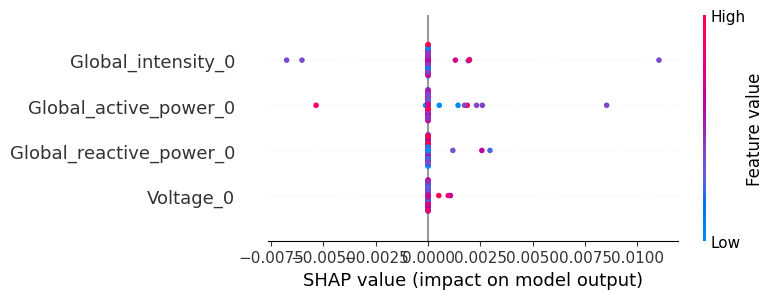

In [42]:
# Summary Plot for each random sample
shap.initjs()
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    shap.summary_plot(shap_values[i].reshape(sequence_length, -1), sample_df, feature_names=feature_names[:input_size * sequence_length], show=False)
    # plt.title(f"SHAP Summary Plot for Sample {random_indices[i]}")
    # plt.savefig(f'./results/shap_summary_plot_sample_{random_indices[i]}.png')
    # plt.show()

### Force plot

각 예측에 대해 피처가 어떻게 영향을 미치는지 시각화

해석 방법
- 예측 값: 중앙의 값은 모델의 예측 값
- 기준 값: 중앙의 값 주위에 빨간색과 파란색 막대 있고, 이 막대들은 피처 값이 예측 값에 미치는 영향을 나타냄
- 빨간색: 피처가 예측 값을 증가시키는 방향으로 영향을 미치는 경우
- 파란색: 피처가 예측 값을 감소시키는 방향으로 영향을 미치는 경우

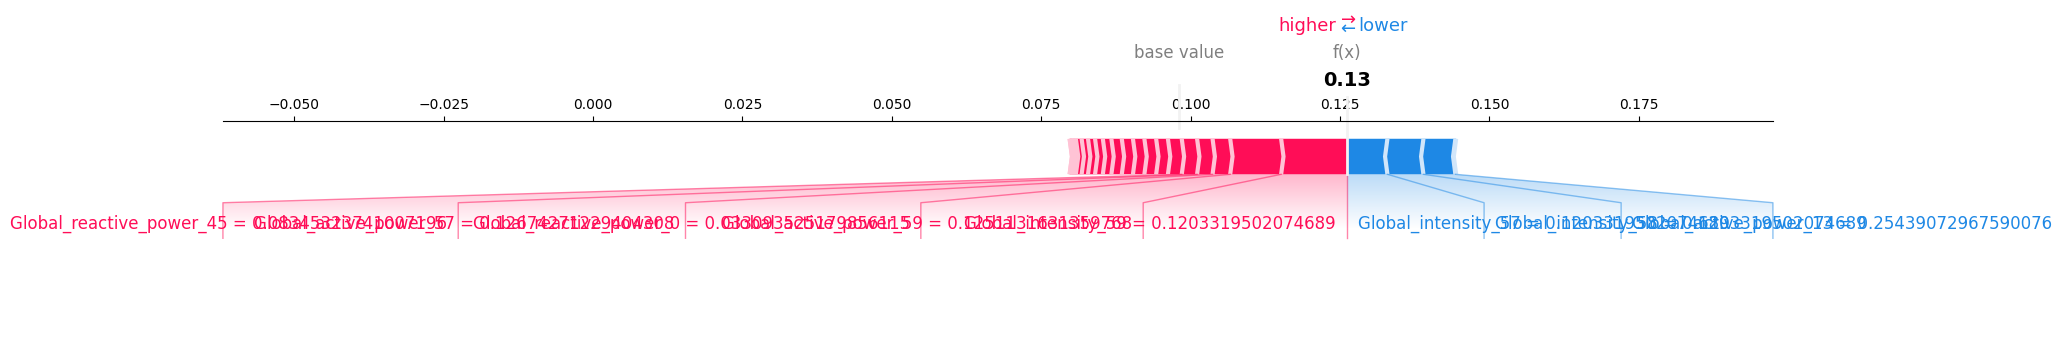

In [64]:
# Force Plot for each random sample
shap.initjs()
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    shap_values_explanation = shap.Explanation(
        values=shap_values[i].reshape(sequence_length * input_size), 
        base_values=np.repeat(explainer.expected_value, sequence_length * input_size), 
        data=sample_df.values.flatten(), 
        feature_names=feature_names[:sequence_length * input_size]
    )
    shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values_explanation.values, 
        features=shap_values_explanation.data, 
        feature_names=shap_values_explanation.feature_names,
        matplotlib=True
    )
    # plt.title(f"SHAP Force Plot for Sample {random_indices[i]}")
    # plt.savefig(f'./results/shap_force_plot_sample_{random_indices[i]}.png')
    # plt.show()

### Waterfall Plot

각 피처가 예측 값에 미치는 영향을 단계적 시각화

해석 방법
- 기준 값: 예측의 기준 값(base value)에서 시작
- 피처 기여도: 각 피처가 예측 값을 얼마나 증가시키거나 감소시키는지 보여줌
- 최종 예측 값: 모든 피처의 기여도를 합한 최종 예측 값을 나타냄

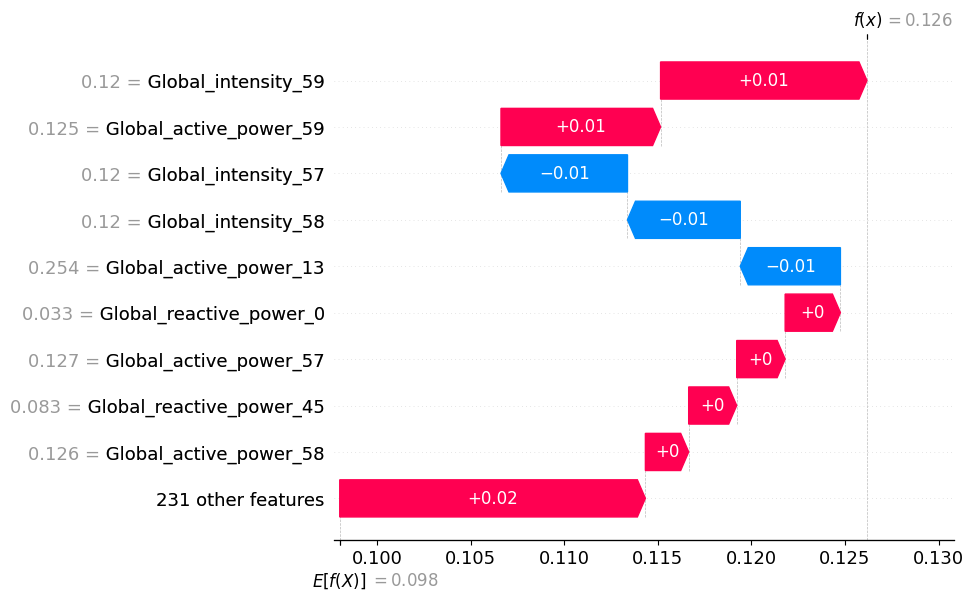

In [44]:
# Waterfall Plot for each random sample
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    shap_values_explanation = shap.Explanation(
        values=shap_values[i].flatten(), 
        base_values=explainer.expected_value, 
        data=sample_df.values.flatten(), 
        feature_names=feature_names[:input_size * sequence_length]
    )
    shap.waterfall_plot(shap_values_explanation)
    # plt.title(f"SHAP Waterfall Plot for Sample {random_indices[i]}")
    # plt.savefig(f'./results/shap_waterfall_plot_sample_{random_indices[i]}.png')
    # plt.show()

### Dependence Plot

특정 피처 값이 모델 예측에 어떻게 영향을 미치는지 시각화

해석 방법
- x축: 선택한 피처의 값
- y축: 선택한 피처의 SHAP 값
- 색상: 다른 피처의 값에 따른 변화를 나타냄

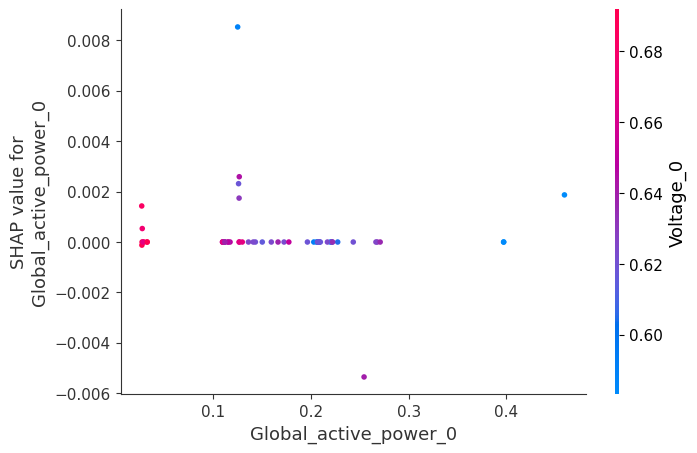

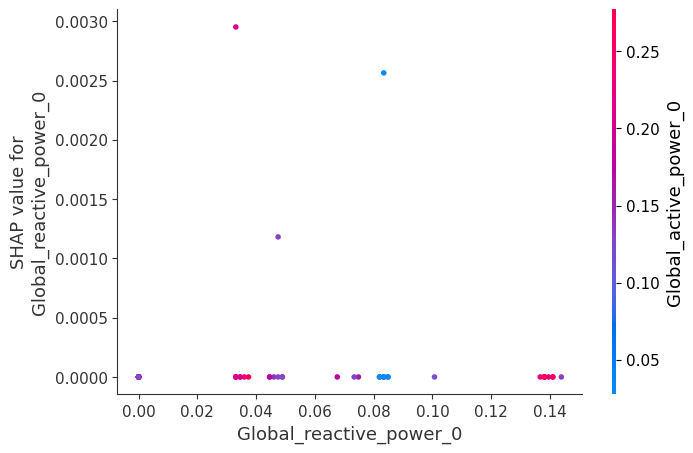

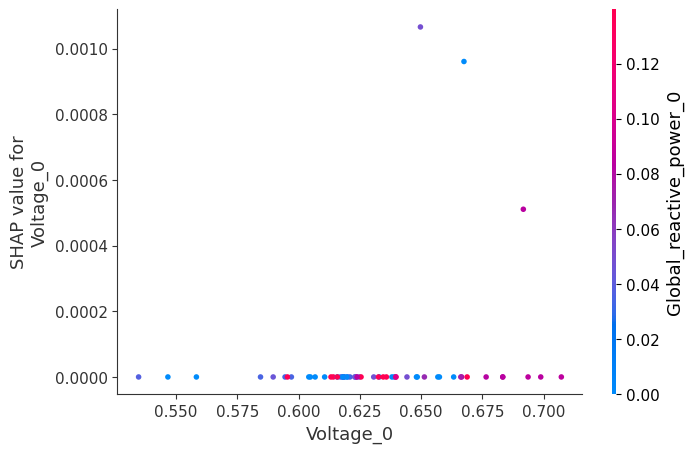

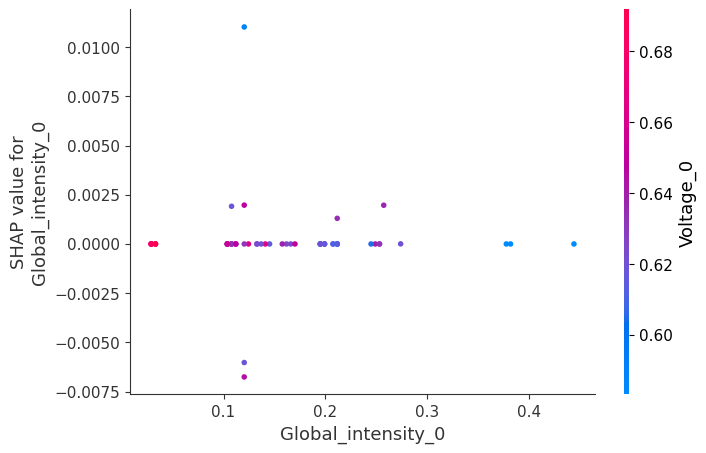

In [45]:
# Dependence Plot for each random sample and feature
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    for feature in selected_features:
        feature_name = f"{feature}_0"
        shap.dependence_plot(feature_name, shap_values[i].reshape(sequence_length, -1), sample_df)
        # plt.title(f"SHAP Dependence Plot for Sample {random_indices[i]}, Feature {feature_name}")
        # plt.savefig(f'./results/shap_dependence_plot_sample_{random_indices[i]}_feature_{feature}.png')
        # plt.show()

### Decision Plot

특정 피처 값이 모델 예측에 어떻게 영향을 미치는지 시각화

해석 방법
- 경로: 각 피처가 예측 값에 미치는 영향을 단계별로 보여줌
- 결정 포인트: 각 피처가 어떻게 예측 값에 기여하는지 명확하게 나타냄

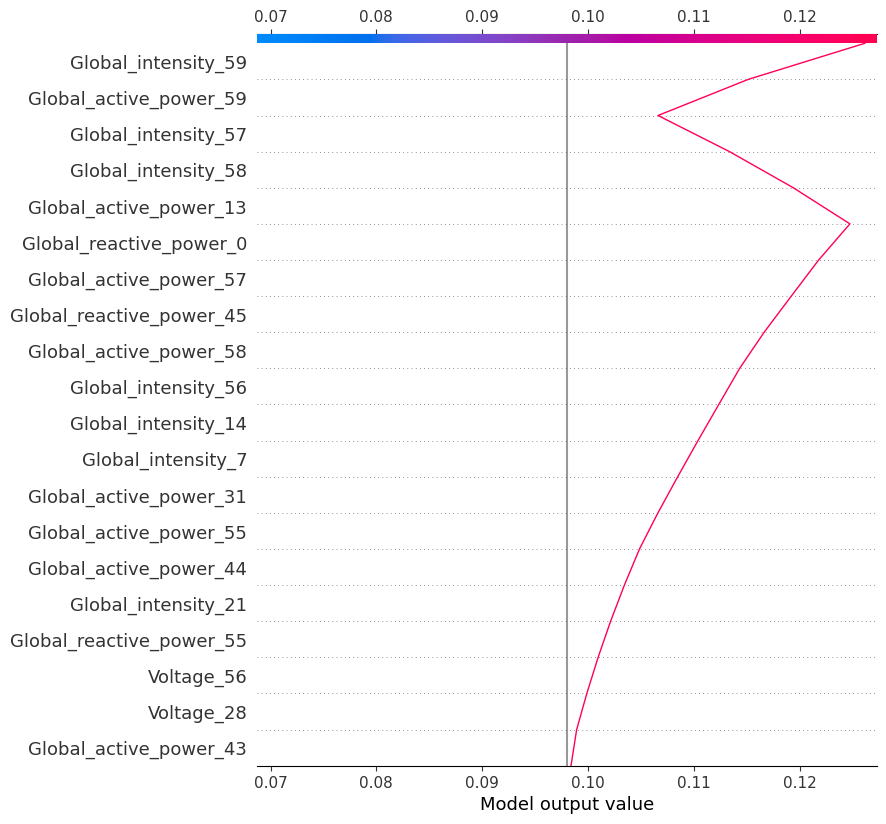

In [46]:
# Decision Plot for each random sample
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    shap_values_explanation = shap.Explanation(
        values=shap_values[i].flatten(), 
        base_values=explainer.expected_value, 
        data=sample_df.values.flatten(), 
        feature_names=feature_names[:input_size * sequence_length]
    )
    shap.decision_plot(explainer.expected_value, shap_values_explanation.values, feature_names=feature_names[:input_size * sequence_length])
    # plt.title(f"SHAP Decision Plot for Sample {random_indices[i]}")
    # plt.savefig(f'./results/shap_decision_plot_sample_{random_indices[i]}.png')
    # plt.show()

### Scatter Plot

두 feature 간의 관계를 시각화하고, 색상을 통해 세 번째 feature의 영향을 시각화

해석 방법:
- x축: 첫 번째 feature의 SHAP 값
- y축: 두 번째 feature의 SHAP 값
- 색상: 세 번째 feature의 값을 나타냄

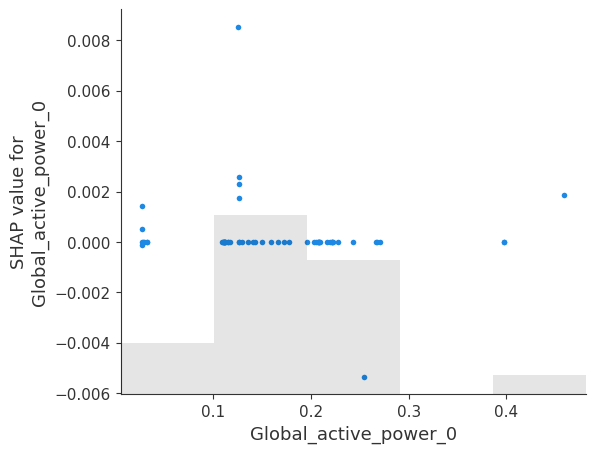

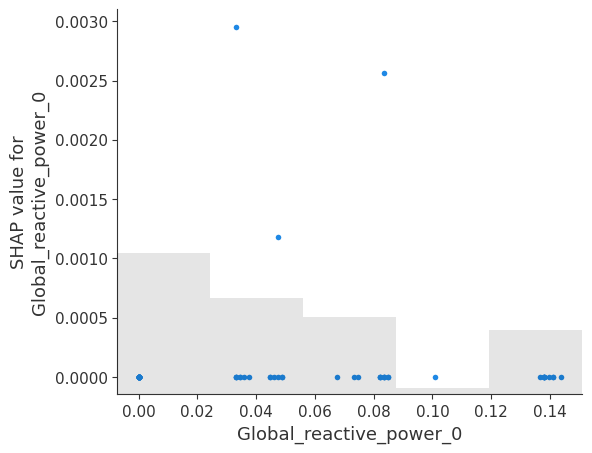

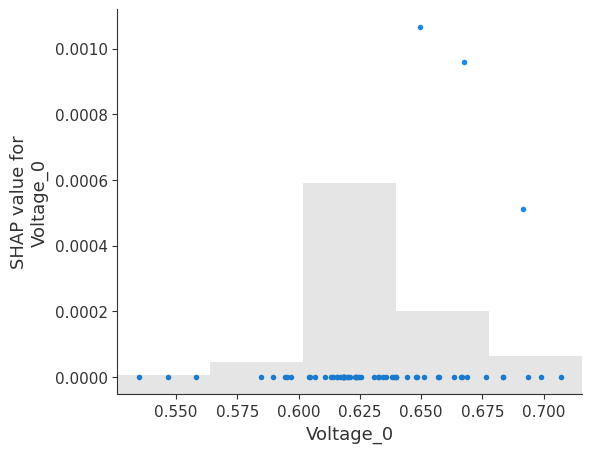

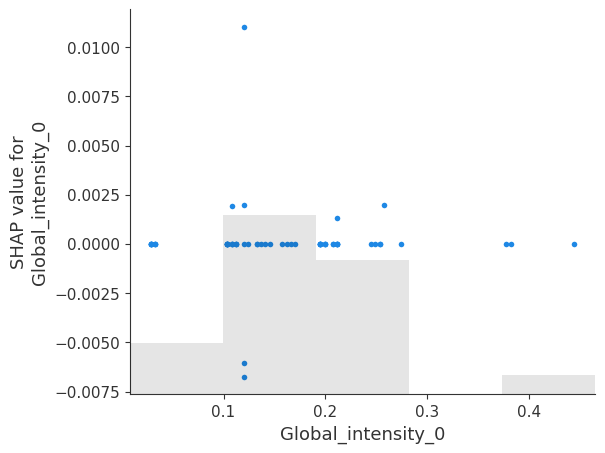

In [54]:
# Scatter Plot for each random sample and feature
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    for feature in selected_features:
        feature_name = f"{feature}_0"
        feature_index = feature_names.index(feature_name)
        shap_values_explanation = shap.Explanation(
            values=shap_values[i].reshape(sequence_length, -1), 
            base_values=np.repeat(explainer.expected_value, sequence_length), 
            data=sample_df.values, 
            feature_names=feature_names[:input_size]
        )
        shap.plots.scatter(shap_values_explanation[:, feature_index])
        # plt.title(f"SHAP Scatter Plot for Sample {random_indices[i]}, Feature {feature_name}")
        # plt.savefig(f'./results/shap_scatter_plot_sample_{random_indices[i]}_feature_{feature}.png')
        # plt.show()

### Bar Plot

각 feature의 평균 SHAP 값을 보여주고, 이를 통해 각 feature의 중요도를 직관적으로 파악

해석 방법:
- y축: feature 이름
- x축: 평균 SHAP 값. 값이 클수록 해당 feature의 중요도가 높음을 나타냄

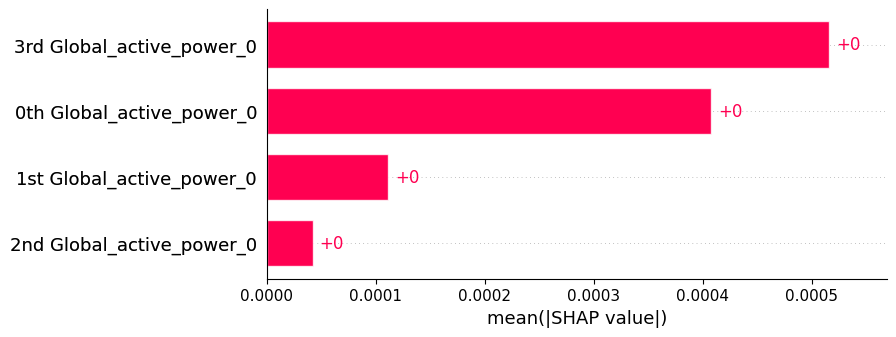

In [47]:
# Bar Plot for multiple features
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    shap_values_explanation = shap.Explanation(
        values=shap_values[i].reshape(sequence_length, -1), 
        base_values=explainer.expected_value, 
        data=sample_df.values, 
        feature_names=feature_names[:input_size * sequence_length]
    )
    shap.plots.bar(shap_values_explanation)
    # plt.title(f"SHAP Bar Plot for Sample {random_indices[i]}")
    # plt.savefig(f'./results/shap_bar_plot_sample_{random_indices[i]}.png')
    # plt.show()

### Beeswarm Plot

Summary Plot과 유사하지만, 각 feature의 SHAP 값 분포를 시각화하고, 이를 통해 feature 값이 예측에 미치는 영향을 더 세밀하게 분석하도록 함

해석 방법:
- y축: feature 이름. 중요도에 따라 나열
- x축: SHAP 값. 오른쪽으로 갈수록 예측값을 증가시키고, 왼쪽으로 갈수록 예측값을 감소시킴
- 색상: feature 값의 크기를 나타냄

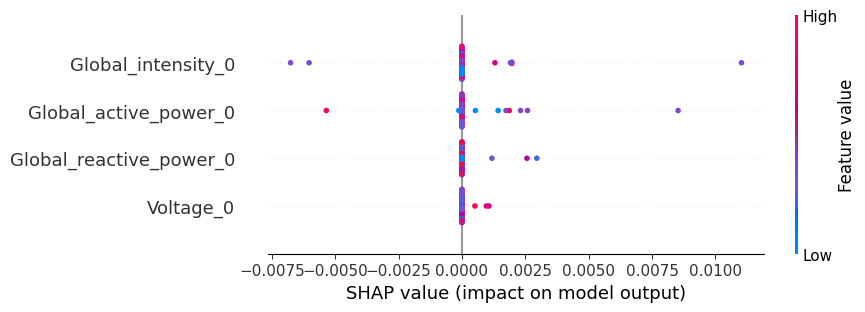

In [48]:
# Beeswarm Plot for each random sample
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    shap_values_explanation = shap.Explanation(
        values=shap_values[i].reshape(sequence_length, -1), 
        base_values=explainer.expected_value, 
        data=sample_df.values, 
        feature_names=feature_names[:input_size * sequence_length]
    )
    shap.plots.beeswarm(shap_values_explanation)
    # plt.title(f"SHAP Beeswarm Plot for Sample {random_indices[i]}")
    # plt.savefig(f'./results/shap_beeswarm_plot_sample_{random_indices[i]}.png')
    # plt.show()

### Heatmap Plot

feature 간의 상관관계를 시각화하여, 이를 통해 어떤 feature들이 서로 상호작용하는지 파악

해석 방법:
- x축과 y축: feature 이름.
- 색상: 상관계수. 진한 색일수록 강한 상관관계를 나타냅니다.

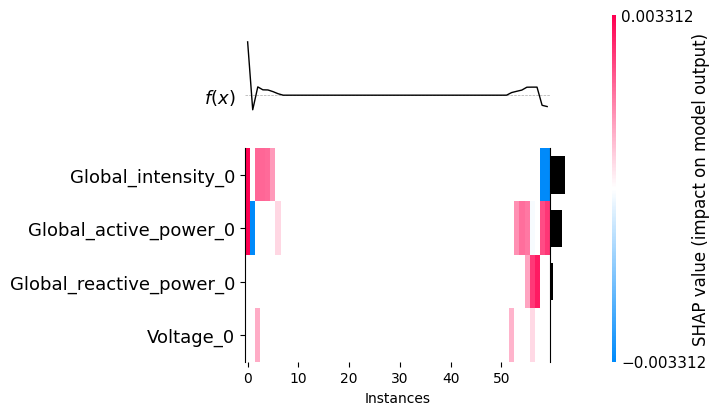

In [49]:
# Heatmap Plot for each random sample
for i in range(num_samples):
    sample_df = sequence_to_dataframe(eval_sequences[random_indices[i]], feature_names, sequence_length, input_size)
    shap_values_explanation = shap.Explanation(
        values=shap_values[i].reshape(sequence_length, -1), 
        base_values=explainer.expected_value, 
        data=sample_df.values, 
        feature_names=feature_names[:input_size * sequence_length]
    )
    shap.plots.heatmap(shap_values_explanation)
    # plt.title(f"SHAP Heatmap Plot for Sample {random_indices[i]}")
    # plt.savefig(f'./results/shap_heatmap_plot_sample_{random_indices[i]}.png')
    # plt.show()

### Partial Dependence Plot

특정 feature가 예측값에 미치는 평균적인 영향을 보여줌. 이를 통해 특정 feature의 값 변화가 예측에 어떻게 영향을 미치는지 분석

해석 방법:
- x축: 특정 feature의 값.
- y축: 예측값의 변화. 특정 feature의 값 변화에 따른 예측값의 변화를 보여줍니다.

In [67]:
# Partial Dependence Plot
# This requires model.predict and a sample of data X
wrapper = PyTorchLSTMModelWrapper(model)
X = random_samples.reshape(num_samples, sequence_length * input_size)

# Use correct feature name for partial dependence plot
feature_name = 'Voltage_0'  # example feature name

# Create a valid SHAP Explanation object for dependence plot
shap_values_explanation = shap.Explanation(
    values=shap_values[0].reshape(num_samples, sequence_length * input_size), 
    base_values=np.repeat(explainer.expected_value, num_samples * sequence_length * input_size), 
    data=X, 
    feature_names=feature_names
)

# Generate the dependence plot
shap.dependence_plot(feature_name, shap_values_explanation)

AttributeError: 'NoneType' object has no attribute 'shape'